# Responsible Data Science Spring 2022: Homework 1

In [5]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

# add
!pip install --upgrade fairlearn==v0.6.0


fatal: destination path 'superquail' already exists and is not an empty directory.


In [6]:
import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

import BlackBoxAuditing
%matplotlib inline

pip install 'aif360[LFR]'


# Problem 2
### **Load and split data** 

#### Load Folktables dataset and set the protected attribute, drop the other protected attribute race


We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [7]:
np.random.seed(13)
protected_attr = 'SEX' #set sex as the protected attribute
target = 'PINCP' #personal income as the target (1=(>50k))

#read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)
full_df = full_df.drop(columns='RAC1P') #drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(70000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4220.0,6.0,10.0,40.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1460.0,457.0,0.0,40.0,1.0,1.0
4,55.0,1.0,16.0,1.0,220.0,6.0,1.0,40.0,1.0,0.0


In [8]:
# convert this dataframe into an aif360 dataset
dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

### Create the train test val split

In [9]:
#YOUR CODE HERE
# Split original data into train and test data
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed = 10) # seed = 10 necessary??
# Split training data into train and validation data for hyperparameter tuning(> validation data)
train_orig, val_orig = train_orig.split([0.875], shuffle=True)

# Conver to dataframe
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (49000, 10)
Val set:  (7000, 10)
Test set:  (14000, 10)


In [10]:
print(train_orig_df.columns)
train_orig_df.head()

Index(['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX',
       'PINCP'],
      dtype='object')


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
18884,62.0,1.0,11.0,1.0,3602.0,247.0,1.0,40.0,2.0,1.0
18842,24.0,1.0,16.0,5.0,5610.0,6.0,2.0,40.0,1.0,0.0
16031,45.0,1.0,8.0,1.0,5610.0,303.0,1.0,40.0,1.0,0.0
69028,59.0,1.0,22.0,1.0,1021.0,210.0,1.0,40.0,1.0,1.0
37596,45.0,1.0,22.0,1.0,3030.0,6.0,1.0,40.0,2.0,1.0


# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) model and report metrics**

### Train a random forest model - Baseline

In [11]:
#YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

X_train = train_orig_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
y_train = train_orig_df[target]

X_test = test_orig_df.drop(target, axis=1)
y_test = test_orig_df[target]

clf = RandomForestClassifier(n_estimators=1, random_state=11)
clf.fit(X_train, y_train)
classified = clf.predict(X_test)

metric_train = BinaryLabelDatasetMetric(
    train_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)


### Calculate Metrics

In [12]:
#YOUR CODE HERE
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate


# accuracy
accuracy = accuracy_score(y_test, classified)
print("Accuracy = %f" % accuracy) # verifying

metric_fns = {'FPR': false_positive_rate,
              'accuracy': accuracy_score}

grouped_on_sex = MetricFrame(metric_fns,
                             y_test, classified,
                             sensitive_features=X_test['SEX'])
print(grouped_on_sex.by_group['accuracy'])

print("Disparate Impact = %f" % metric_train.disparate_impact())

FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
print("False positive rate difference: %f " % FPRdiff)

Accuracy = 0.740571
SEX
1.0    0.732752
2.0    0.749175
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.053378 


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline RF model**

In [13]:
# for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

### Define a program to conduct tune the Random Forest
Optimize the AUC (-> Accuracy). You should try the following hyperparameters: <br>
max_depth=[1, 5, 10] <br>
n_estimators=[1, 5, 10, 15, 20]

In [14]:
max_depth=[1, 5, 10]
n_estimators=[1, 5, 10, 15, 20]

# Split original data into train and test data
train_sub, test_sub = dataset_orig.split([0.8], shuffle=True, seed = 10) # seed = 10 necessary??
# Split training data into train and validation data for hyperparameter tuning(> validation data)
train_sub, val_sub = train_sub.split([0.875], shuffle=True, seed = 10)

train_sub_df, _ = train_sub.convert_to_dataframe()
val_sub_df, _ = val_sub.convert_to_dataframe()
test_sub_df, _ = test_sub.convert_to_dataframe()

X_train = train_sub_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
y_train = train_sub_df[target]
      
X_val = val_sub_df.drop(target, axis=1)
y_val = val_sub_df[target]

X_test = test_sub_df.drop(target, axis=1)
y_test = test_sub_df[target]

accuracies = []
for i in range(0, len(max_depth)):
    for j in range(0, len(n_estimators)):
      
      clf = RandomForestClassifier(max_depth=max_depth[i], n_estimators=n_estimators[j], random_state=11)
      clf.fit(X_train, y_train)
      classified = clf.predict(X_val)
      
      accuracy = accuracy_score(y_val, classified)
      accuracies.append([accuracy, (max_depth[i], n_estimators[j])])

accuracies.sort(reverse=True)
_, best_hyperparameters = accuracies[0]
best_depth, best_n_estimator = best_hyperparameters[0], best_hyperparameters[1]
print("Best depth: ", best_depth)
print("Best n_estimators: ", best_n_estimator)

Best depth:  10
Best n_estimators:  20


### Compare the initial model to the fine-tuned model for 10 train/val/test 
splits for Random Forest

In [15]:
from pandas.core.common import random_state
SPLITS = 10

init_accuracies = []
tuned_accuracies = []

init_privileged = []
tuned_privileged = []

init_unprivileged = []
tuned_unprivileged = []

init_disparate_impacts = []
tuned_disparate_impacts = []

init_fpr = []
tuned_fpr = []


for i in range(SPLITS):
  # Split original data into train and test data
  train_sub, test_sub = dataset_orig.split([0.8], shuffle=True, seed = i) # seed = 10 necessary??
  # Split training data into train and validation data for hyperparameter tuning(> validation data)
  train_sub, val_sub = train_sub.split([0.875], shuffle=True, seed = i)

  # Conver to dataframe
  train_sub_df, _ = train_sub.convert_to_dataframe()
  val_sub_df, _ = val_sub.convert_to_dataframe()
  test_sub_df, _ = test_sub.convert_to_dataframe()

  X_train = train_sub_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
  y_train = train_sub_df[target]
      
  X_val = val_sub_df.drop(target, axis=1)
  y_val = val_sub_df[target]

  X_test = test_sub_df.drop(target, axis=1)
  y_test = test_sub_df[target]

  # initial model
  initial_clf = RandomForestClassifier(n_estimators=1, random_state=11)
  initial_clf.fit(X_train, y_train)
  initial_classified = initial_clf.predict(X_test)

  accuracy = accuracy_score(y_test, initial_classified)

  metric_fns = {'FPR': false_positive_rate,
                'accuracy': accuracy_score}
  
  grouped_on_sex = MetricFrame(metric_fns,
                               y_test, initial_classified,
                               sensitive_features=X_test['SEX'])
  
  idx = 0
  for row in grouped_on_sex.by_group['accuracy']:
    if idx == 0:
      init_privileged.append(row)
      idx += 1
    elif idx == 1:
      init_unprivileged.append(row)

  test_orig_df = X_test.copy()
  test_orig_df[target] = initial_classified

  orig_aif360 = StandardDataset(test_orig_df, label_name=target, protected_attribute_names=['SEX'],
                                privileged_classes=[[1]], favorable_classes=[1])
  
  orig_metrics = BinaryLabelDatasetMetric(orig_aif360,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups)
  
  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  #print("False positive rate difference: %f" % FPRdiff)

  init_accuracies.append(accuracy)
  init_disparate_impacts.append(orig_metrics.disparate_impact())
  init_fpr.append(FPRdiff)

  
  # fine-tuned model
  tuned_clf = RandomForestClassifier(max_depth=best_depth, n_estimators=best_n_estimator, random_state=11)
  tuned_clf.fit(X_train, y_train)
  tuned_classified = tuned_clf.predict(X_test)
  
  accuracy = accuracy_score(y_test, tuned_classified)

  grouped_on_sex = MetricFrame(metric_fns,
                               y_test, tuned_classified,
                               sensitive_features=X_test['SEX'])
  
  idx = 0
  for row in grouped_on_sex.by_group['accuracy']:
    if idx == 0:
      tuned_privileged.append(row)
      idx += 1
    elif idx == 1:
      tuned_unprivileged.append(row)
  
  #print('Accuracy: ', grouped_on_sex.by_group['accuracy'])

  tuned_test_df = X_test.copy()
  tuned_test_df[target] = tuned_classified

  pred_aif360 = StandardDataset(tuned_test_df, label_name=target, protected_attribute_names=['SEX'],
                                privileged_classes=[[1]], favorable_classes=[1])
  
  pred_metrics = BinaryLabelDatasetMetric(pred_aif360,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups)

  #print("Disparate Impact = %f" % pred_metrics.disparate_impact()) # TODO: metric_train 같아도 되는지

  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  #print("False positive rate difference: %f" % FPRdiff)

  tuned_accuracies.append(accuracy)
  tuned_disparate_impacts.append(pred_metrics.disparate_impact())
  tuned_fpr.append(FPRdiff)


In [16]:
for i in range(SPLITS):
  print("==================== ", i,  "th data ====================")
  print("Accuracy: ", init_accuracies[i], " -> ", tuned_accuracies[i])
  print("Accuracy for privileged:", init_privileged[i], " -> ", tuned_privileged[i])
  print("Accuracy for unprivileged: ", init_unprivileged[i], " -> ", tuned_unprivileged[i])
  print("Disparate Impact: ", init_disparate_impacts[i], " -> ", tuned_disparate_impacts[i])
  print("False positive rate difference: ", init_fpr[i], " -> ", tuned_fpr[i])

====================  0 th data ====================
Accuracy:  0.7396428571428572  ->  0.8053571428571429
Accuracy for privileged: 0.7343193645576555  ->  0.7974527526705012
Accuracy for unprivileged:  0.7454464019110182  ->  0.8139743206927441
Disparate Impact:  0.7255101723041059  ->  0.6840016404086653
False positive rate difference:  -0.05820408662627333  ->  -0.07058196791449861
====================  1 th data ====================
Accuracy:  0.7412142857142857  ->  0.8140714285714286
Accuracy for privileged: 0.7334410339256866  ->  0.8065428109854604
Accuracy for unprivileged:  0.75  ->  0.8225806451612904
Disparate Impact:  0.7924966097532328  ->  0.7704866252169278
False positive rate difference:  -0.04592106742715507  ->  -0.039100177760977295
====================  2 th data ====================
Accuracy:  0.7385714285714285  ->  0.8120714285714286
Accuracy for privileged: 0.7310683585755219  ->  0.8067949242734344
Accuracy for unprivileged:  0.746814570529156  ->  0.817868385

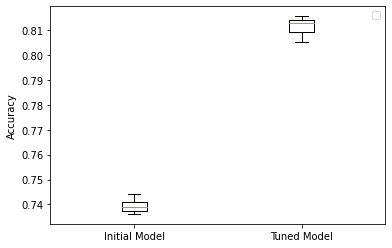

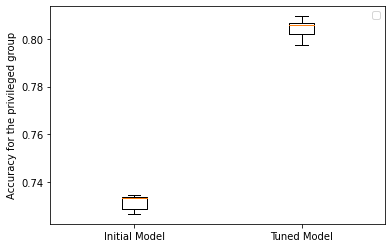

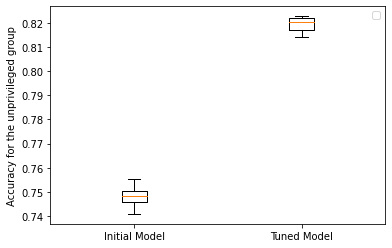

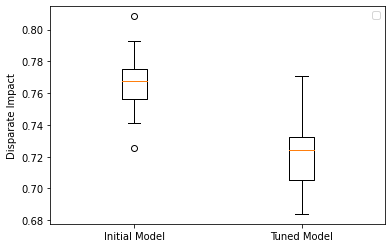

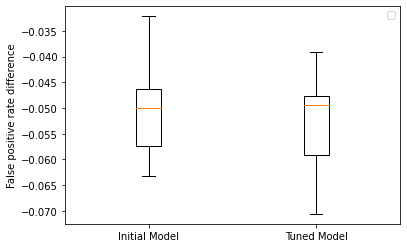

In [17]:
plot_init_v_tuned_box(init_accuracies, tuned_accuracies, "Accuracy")
plot_init_v_tuned_box(init_privileged, tuned_privileged, "Accuracy for the privileged group")
plot_init_v_tuned_box(init_unprivileged, tuned_unprivileged, "Accuracy for the unprivileged group")
plot_init_v_tuned_box(init_disparate_impacts, tuned_disparate_impacts, "Disparate Impact")
plot_init_v_tuned_box(init_fpr, tuned_fpr, "False positive rate difference")

# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [18]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

### Apply pre-processing techniques to the dataset, then re-train the models with the optimal hyperparameters from part **b**

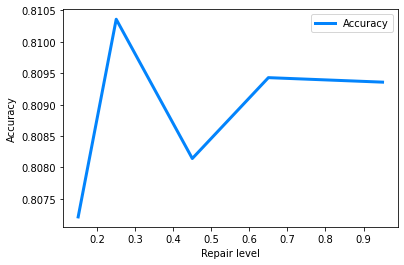

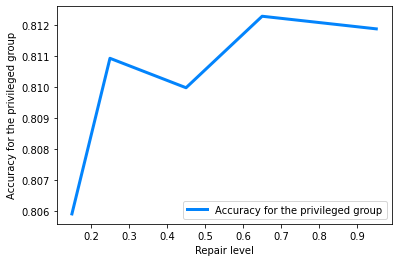

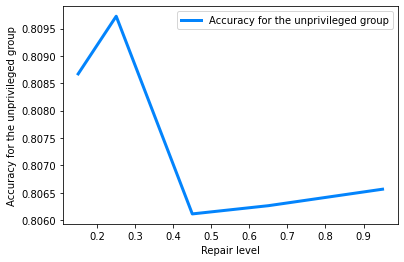

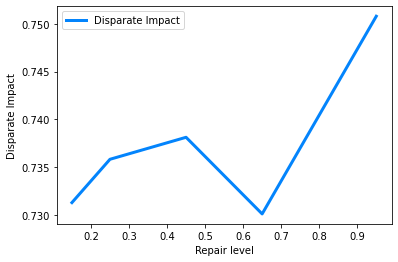

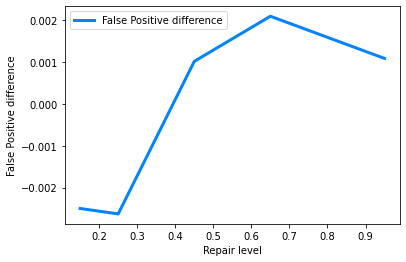

In [19]:
#YOUR CODE HERE
from sklearn.model_selection import train_test_split

# 5 metrics
accuracies = []
accuracies_privileged = []
accuracies_unprivileged = []
disparate_impacts = []
FPRdiffenrences = []

def test_disparate_impact_remover(repair_level):
  # preprocessing
  di = DisparateImpactRemover(repair_level = repair_level)
  dataset_transf_train = di.fit_transform(dataset_orig)
  transformed = dataset_transf_train.convert_to_dataframe()[0]
  
  X_trans = transformed.drop([target], axis = 1)
  y_trans = transformed[target]
  
  # TODO check split to validation set?
  X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_trans, y_trans, test_size=0.2, random_state=3)
  X_trans_train, X_trans_val, y_trans_train, y_trans_val = train_test_split(X_trans_train, y_trans_train, test_size=0.125, random_state=3)
  
  clf = RandomForestClassifier(max_depth=best_depth, n_estimators=best_n_estimator, random_state=11)
  clf.fit(X_trans_train, y_trans_train)
  y_predict = clf.predict(X_trans_test)
  
  # metrics
  accuracy = accuracy_score(y_trans_test, y_predict)
  accuracies.append(accuracy)
  
  metric_fns = {'FPR': false_positive_rate,
                'accuracy': accuracy_score}
                
  grouped_on_sex = MetricFrame(metric_fns,
                               y_trans_test, y_predict,
                               sensitive_features = X_test['SEX'])
  
  idx = 0
  for row in grouped_on_sex.by_group['accuracy']:
    if idx == 0:
      accuracies_privileged.append(row)
      idx += 1
    elif idx == 1:
      accuracies_unprivileged.append(row)
  
  #print(grouped_on_sex.by_group['accuracy'])
  
  trans_pred_df = X_trans_test.copy()
  trans_pred_df[target] = y_predict

  pred_aif360 = StandardDataset(trans_pred_df, label_name=target, protected_attribute_names=['SEX'],
                                privileged_classes=[[1]], favorable_classes=[1])
  
  pred_metrics = BinaryLabelDatasetMetric(pred_aif360,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups)

  disparate_impacts.append(pred_metrics.disparate_impact())
  
  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  FPRdiffenrences.append(FPRdiff)


repair_levels = [0.15, 0.25, 0.45, 0.65, 0.95]
#repair_levels = [0.1, 0.25, 0.45, 0.75, 0.9]


for rl in repair_levels:
  test_disparate_impact_remover(rl)

plot_repair_levels(repair_levels, accuracies, 'Accuracy')
plot_repair_levels(repair_levels, accuracies_privileged, 'Accuracy for the privileged group')
plot_repair_levels(repair_levels, accuracies_unprivileged, 'Accuracy for the unprivileged group')
plot_repair_levels(repair_levels, disparate_impacts, 'Disparate Impact')
plot_repair_levels(repair_levels, FPRdiffenrences, 'False Positive difference')

# Problem 2, Part (d) 
### **Prejudice Remover In-Processing intervention**



### Fit new models using the Prejudice Remover technique

In [20]:
from aif360.algorithms import preprocessing

# X_train, y_train = splitted_X_trains[0], splitted_y_trains[0]
# X_test, y_test = splitted_X_tests[0], splitted_y_tests[0]

pr_accuracies = []
pr_disparate_impacts = []

etas = [0.01, 0.1, 1]

for eta in etas:
  pr = PrejudiceRemover(eta=eta)
  
  # convert this dataframe into an aif360 dataset
  train_data = X_train.copy()
  train_data[target] = y_train
  train_aif360 = StandardDataset(train_data, label_name=target, protected_attribute_names=['SEX'],
                                 privileged_classes=[[1]], favorable_classes=[1])
  
  
  
  # train_metrics = BinaryLabelDatasetMetric(train_aif360,
  #                                          unprivileged_groups=unprivileged_groups,
  #                                          privileged_groups=privileged_groups)

  pr = pr.fit(train_aif360)

  test_data = X_test.copy()
  test_data[target] = y_test
  test_aif360 = StandardDataset(test_data, label_name=target, protected_attribute_names=['SEX'],
                                privileged_classes=[[1]], favorable_classes=[1])
  
  y_pred = pr.predict(test_aif360)
  
  test_metrics = BinaryLabelDatasetMetric(y_pred,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups)
  print(test_metrics.disparate_impact())
  
  #y_pred_df, _ = y_pred.convert_to_dataframe()
  accuracy = accuracy_score(y_test, y_pred.labels)
  pr_accuracies.append(accuracy)

  disparate_impact = test_metrics.disparate_impact()
  pr_disparate_impacts.append(disparate_impact)
  print('Accuracy: ', accuracy)
  print('Disparate Impact: %f' % disparate_impact)




0.6535746247002947
Accuracy:  0.7485
Disparate Impact: 0.653575
0.6457137615166143
Accuracy:  0.7485
Disparate Impact: 0.645714
0.6502673538126007
Accuracy:  0.7485714285714286
Disparate Impact: 0.650267


In [21]:
def plot_etas(etas, metric_vals, metric_name, x_label='Repair level'):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(etas, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

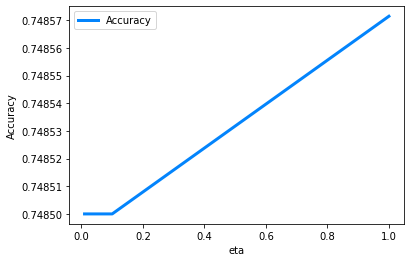

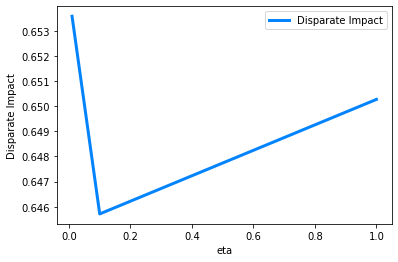

In [22]:
plot_etas(etas, pr_accuracies, 'Accuracy', x_label='eta')
plot_etas(etas, pr_disparate_impacts, 'Disparate Impact', x_label='eta')

# Problem 2, Part (e) 
### **Reject Option Post-Processing intervention**

### Using the same random forest models as before, apply the post-processing technique to your results and compare

In [23]:
import aif360.algorithms.postprocessing
from IPython.display import Markdown, display

SPLITS = 10

# 5 metrics
accuracies = []
accuracies_privileged = []
accuracies_unprivileged = []
disparate_impacts = []
FPRdiffenrences = []

for i in range(SPLITS):
  # Split original data into train and test data
  train_sub, test_sub = dataset_orig.split([0.8], shuffle=True, seed = i) # seed = 10 necessary??
  # Split training data into train and validation data for hyperparameter tuning(> validation data)
  train_sub, val_sub = train_sub.split([0.875], shuffle=True, seed = i)

  # Conver to dataframe
  train_sub_df, _ = train_sub.convert_to_dataframe()
  val_sub_df, _ = val_sub.convert_to_dataframe()
  test_sub_df, _ = test_sub.convert_to_dataframe()

  X_train = train_sub_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
  y_train = train_sub_df[target]
      
  X_val = val_sub_df.drop(target, axis=1)
  y_val = val_sub_df[target]

  X_test = test_sub_df.drop(target, axis=1)
  y_test = test_sub_df[target]

  train_data = X_train.copy()
  train_data[target] = y_train
  train_aif360 = StandardDataset(train_data, label_name=target, protected_attribute_names=['SEX'],
                                 privileged_classes=[[1]], favorable_classes=[1])
  
  val_data_orig = X_val.copy()
  val_data_orig[target] = y_val
  val_orig_aif360 = StandardDataset(val_data_orig, label_name=target, protected_attribute_names=['SEX'],
                                    privileged_classes=[[1]], favorable_classes=[1])
  
  # test data for prediction?
  test_data = X_test.copy()
  test_data[target] = y_test
  test_aif360 = StandardDataset(test_data, label_name=target, protected_attribute_names=['SEX'],
                                privileged_classes=[[1]], favorable_classes=[1])
  
  clf = RandomForestClassifier(max_depth=10, n_estimators=15)
  clf.fit(train_aif360.features, train_aif360.labels.ravel())
  y_pred = clf.predict(test_aif360.features).reshape(-1,1)
  
  predicted_data = test_aif360.copy()
  predicted_data.labels = y_pred
# predicted_aif360 = StandardDataset(predicted_data, label_name=target, protected_attribute_names=['SEX'],
#                               privileged_classes=[[1]], favorable_classes=[1])
  pos_ind = np.where(clf.classes_ == val_orig_aif360.favorable_label)[0][0]
  predicted_data.scores = clf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

  ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                  privileged_groups=privileged_groups, 
                                  low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50)

  ROC = ROC.fit(test_aif360, predicted_data)
  test_pred = ROC.predict(predicted_data)

  fav_inds = predicted_data.scores > ROC.classification_threshold
  predicted_data.labels[fav_inds] = predicted_data.favorable_label
  predicted_data.labels[~fav_inds] = predicted_data.unfavorable_label

  display(Markdown("#### Validation set"))
  display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

  test_predicted_df, _ = test_pred.convert_to_dataframe()

  accuracy = accuracy_score(y_test, test_predicted_df[target])
  print('Accuracy: ', accuracy)
  accuracies.append(accuracy)

  metric_fns = {'FPR': false_positive_rate,
              'accuracy': accuracy_score}
  
  grouped_on_sex = MetricFrame(metric_fns,
                             y_test, test_predicted_df[target],
                             sensitive_features=X_test['SEX'])
  
  idx = 0
  for row in grouped_on_sex.by_group['accuracy']:
    if idx == 0:
      print('privileged: ', row)
      accuracies_privileged.append(row)
      idx += 1
    elif idx == 1:
      print('unprivileged: ', row)
      accuracies_unprivileged.append(row)

  metrics = BinaryLabelDatasetMetric(test_pred,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

  disparate_impact = metrics.disparate_impact()
  print("Disparate Impact = %f" % disparate_impact)
  disparate_impacts.append(disparate_impact)

  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  print("False positive rate difference: %f" % FPRdiff)
  FPRdiffenrences.append(FPRdiff)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.7958571428571428
privileged:  0.7990961380443714
unprivileged:  0.7923260674828307
Disparate Impact = 0.908187
False positive rate difference: 0.023066


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8074285714285714
privileged:  0.8060043080236942
unprivileged:  0.8090383444917834
Disparate Impact = 0.900053
False positive rate difference: 0.005507


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8081428571428572
privileged:  0.8093873652612907
unprivileged:  0.8067755958626892
Disparate Impact = 0.914475
False positive rate difference: 0.027320


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8067142857142857
privileged:  0.8076455491017155
unprivileged:  0.8056692435955738
Disparate Impact = 0.914170
False positive rate difference: 0.020907


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.7994285714285714
privileged:  0.8018139975632869
unprivileged:  0.7967639497958566
Disparate Impact = 0.911531
False positive rate difference: 0.021689


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8011428571428572
privileged:  0.804920913884007
unprivileged:  0.7969104952294411
Disparate Impact = 0.918862
False positive rate difference: 0.024174


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8057857142857143
privileged:  0.8061034115138592
unprivileged:  0.8054187192118226
Disparate Impact = 0.906350
False positive rate difference: 0.026616


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8013571428571429
privileged:  0.8034993270524899
unprivileged:  0.7989345509893455
Disparate Impact = 0.912120
False positive rate difference: 0.018085


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.8020714285714285
privileged:  0.8032293377120964
unprivileged:  0.800806933652122
Disparate Impact = 0.901290
False positive rate difference: 0.012766


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy:  0.7991428571428572
privileged:  0.80209324452902
unprivileged:  0.7958753575191931
Disparate Impact = 0.918293
False positive rate difference: 0.032997
